# NN (L) Global Sustainable Equity time series forecasting using ARIMA models

## Start timing the ETL and forecast

In [1]:
import timeit
start_time = timeit.default_timer()

## Import all the necessary libraries

In [2]:
# ## Import all the necessary libraries
import time
import os
import datetime as dt
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np

## Import, clean and visualise the historical data

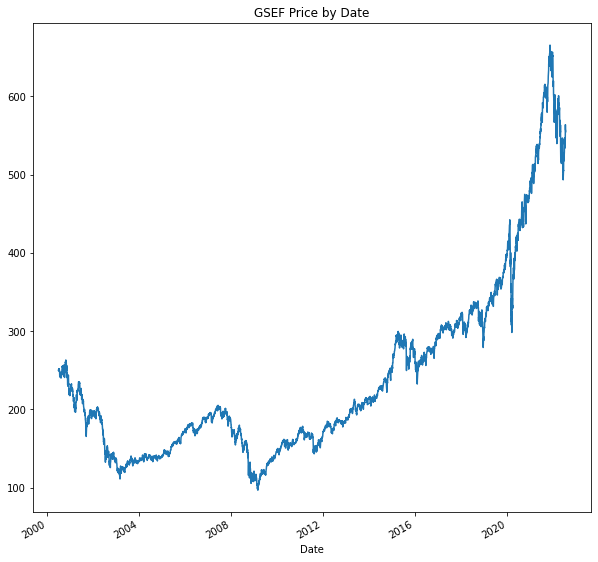

In [3]:
pd.set_option('display.max_column',None)
tomorrow = (dt.date.today() + dt.timedelta(days=1)).isoformat() #get tomorrow in iso format as needed'''
url = pd.read_html("https://markets.ft.com/data/funds/tearsheet/historical?s=LU0119216553:EUR", header=0)
table = url[0]
gsef_latest = table[['Date', 'Close']]
gsef_latest_selected= gsef_latest.copy()

gsef_latest_selected['Date'] = gsef_latest_selected.loc[:,'Date'].str[-12:]
gsef_latest_selected['Date'] = pd.to_datetime(gsef_latest_selected['Date'], dayfirst=True)

gsef_historical= pd.read_csv('gsef_output/historical_gsef.csv', parse_dates=['Date'], dayfirst=True)

gsef = pd.concat([gsef_latest_selected, gsef_historical], ignore_index=True).sort_values(by="Date")

gsef = gsef.reset_index(drop=True)

gsef['pct_change']= (gsef["Close"].pct_change()*100).round(2)

gsef = gsef.drop_duplicates('Date')

gsef.to_csv('gsef_output/historical_gsef.csv', index=False)

# Drop extra columns
gsef = gsef.drop('pct_change', axis=1)

gsef.plot(x= 'Date', y='Close', figsize=(10,10), title= 'GSEF Price by Date', legend=False)

historical_chart= 'gsef_output/gsef_historical.png'

# Check if the historical data's chart exists and save its latest version
if os.path.exists(historical_chart):
  os.remove(historical_chart)
else:
  print("The historical chart didn't exist and it has been created.")

plt.savefig('gsef_output/gsef_historical.png')

plt.show()

In [4]:
# Brief Description of our dataset
gsef.describe()

,Close
count,5568.000000
mean,240.479648
std,119.030671
min,96.810000
25%,157.527500
50%,195.885000
75%,293.070000
max,665.450000


In [5]:
gsef.info() # Check whether the date is as object type or date type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5568 entries, 0 to 5587
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5568 non-null   datetime64[ns]
 1   Close   5568 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 130.5 KB


In [16]:
# Set index as "Date" column
gsef = gsef.set_index('Date')

In [17]:
gsef.head()

,Close
Date,
2000-07-07,250.00
2000-07-10,250.00
2000-07-11,250.00
2000-07-12,249.61
2000-07-13,249.80


## EDA

It is important that we can explicitly control which axis different time series are plotted on. This will be important so we can evaluate our time series predictions later.

Here we plot the daily historical price of the NN (L) Global Sustainable Equity fund. We check out how this quantity has changed over time and how it changes throughout the year.

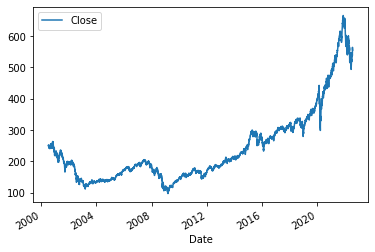

In [18]:
# Plot and show the time series on axis ax1
fig, ax1 = plt.subplots()
gsef.plot(ax=ax1)
plt.show()

Next, we split the data into a train and a test set and plot it so that we can test the quality of our model fit after fitting it.

In [19]:
gsef_train, gsef_test = gsef[0:int(len(gsef)*0.90)], gsef[int(len(gsef)*0.90):]

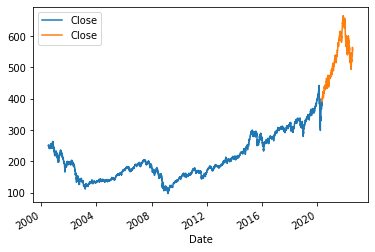

In [20]:
# Create an axis
fig, ax = plt.subplots()

# Plot the train and test sets on the axis ax
gsef_train.plot(ax=ax)
gsef_test.plot(ax=ax)
plt.show()

## Is this time series stationary? Augmented Dicky-Fuller

Identifying whether a time series is stationary or non-stationary is very important. If it is stationary we can use ARMA models to predict the next values of the time series. If it is non-stationary then we will need to transform the non-stationary time series to a stationary one.

At first sight, this time series seems to be non-stationary due to the trend that appears in the time series plot, additionally the variance appears to change over time, whcih is another sign that this dataset is non-stationary.

In this step we will examine the fund's price in order to identify if this dataset is ready for ARMA modeling, or if we will need to further transform it to make it stationary.

In this step we will run the augmented Dicky-Fuller test on the time series to test for stationarity. We plotted this time series in the previous step. It looked like it could be non-stationary. If we want to make predictions about it we better be sure. If it were not stationary this would mean that the price has a trend and that its variance is changing.

In [21]:
from statsmodels.tsa.stattools import adfuller

adf_results = adfuller(gsef['Close'])

# Print test statistic
print('ADF Statistic:', adf_results[0])

# Print p-value
print('p-value:',adf_results[1])

# Print critical values
print(adf_results[4])

ADF Statistic: 1.0953910268904583
p-value: 0.9951770942794353
{'1%': -3.4315315665877675, '5%': -2.8620621358100085, '10%': -2.567047931608169}


The null hypothesis in the Dicky-Fuller test is that the data is non-stationary.
Since the p-value here is not ≤ 0.05, this indicates that we've proven that the stationary effect does not exist and that we accept the null hypothesis. Therefore this time series is non-stationary. We probably could have intuited this from looking at the graph or by knowing a little about stock market.

## Taking the difference

Since this series is non-stationary, we need to convert it to stationary. To do this, we will take the first difference of the data dropping the NaN values. Assign this to gsef_stationary and run the test again.

In [22]:
# Calculate the first difference of the time series
gsef_stationary = gsef.diff().dropna()

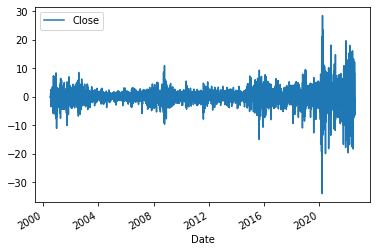

ADF Statistic: -13.879045764551638
p-value: 6.260221046361436e-26


In [23]:
# Run ADF test on the differenced time series
result_diff_1 = adfuller(gsef_stationary['Close'])

# Plot the differenced time series
fig, ax = plt.subplots()
gsef_stationary.plot(ax=ax)
plt.show()

# Print the test statistic and the p-value
print('ADF Statistic:', result_diff_1[0])
print('p-value:', result_diff_1[1])

Since the p-value here is still ≥ 0.05, we take the second difference of gsef, by applying the .diff() method twice and droping the NaN values. To calculate second or higher order differences, we can simply use the .diff() method two or more times. eg df.diff().diff()

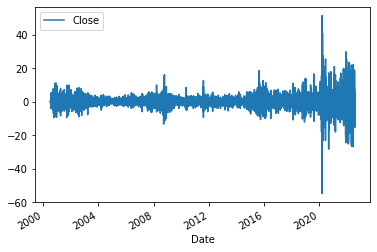

ADF Statistic: -22.60603386210702
p-value: 0.0


In [24]:
# Calculate the second difference of the time series
gsef_stationary = gsef.diff().diff().dropna()

# Run ADF test on the differenced time series
result_diff_2 = adfuller(gsef_stationary['Close'])

# Plot the differenced time series
fig, ax = plt.subplots()
gsef_stationary.plot(ax=ax)
plt.show()

# Print the test statistic and the p-value
print('ADF Statistic:', result_diff_2[0])
print('p-value:', result_diff_2[1])

Amazing! A p-value of 0.0 is very significant!
This time series is now stationary and ready for modeling.

Differencing should be the first transform you try to make a time series stationary. But sometimes it isn't the best option.

A classic way of transforming stock time series is the log-return of the series. Here, we will compare the log-return transform and the first order difference of the GSEF time series to find out which is better for making the time series stationary. The log return on the GSEF time series to test for stationarity is calculated as follows:

In [25]:
# Calculate log-return and drop nans
gsef_log = np.log(gsef/gsef.shift(1))
gsef_log = gsef_log.dropna()

# Run test and print
result_log = adfuller(gsef_log['Close'])
print('ADF Statistic:', result_log[0])
print('p-value:', result_log[1])

ADF Statistic: -23.70894665844648
p-value: 0.0


Great!

Both the differenced and the log-return transformed time series have a small p-value, but the log transformed time series has a more negative test statistic. This means the log-return tranformation is better. Which is why we will use the log-return tranformed dataframe "gsef_log" in our model.

In [26]:
#gsef_log

## Fitting an ARIMA model

In this step we will fit an ARIMA model to the transformed dataset. We have seed that the dataset is now stationary so we don't need to transform it further andd it's ready for modeling.

In [36]:
#from statsmodels.tsa.arima.model import ARIMA

# Next: 

1) Try to add monthly the US Consumer Price Index (https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/) to the data of each day since the beginning of the data as an exogenous input (variable) to create an ARMAX model. Where CPI is missing, take the US CPI value of the previous obesrvation (ffill). z1 would be monthly US CPI. A) Import it from the "us_cpi" csv. B) Merge it based on the Year and month columns C) Run all transformation and analysis steps on the dataset including the exogenous variable (CPI) D) Fit the model using the code that is in the following cell

2) Try to add monthly Euro Consumer Price Index (https://fred.stlouisfed.org/series/EA19CPALTT01IXNBM) to the data of each day since the beginning of the data as an exogenous input (variable) to create an ARMAX model. Where CPI is missing, take the US CPI value of the previous obesrvation (ffill). z2 would be monthly Euro CPI.

3) Fit an ARMAX model on the series as well as the 2 exogenous variables.

## Calculate the analysis' and forecast's timing

In [7]:
# Calculate and print the time elapsed to run ETL process and the date and time of the latest run
time_elapsed = timeit.default_timer() - start_time

time_elapsed_minutes = int((time_elapsed % 3600) // 60)

time_elapsed_seconds = int(time_elapsed % 60)

now = dt.datetime.now()

print("\n Success! Your GSEF forecast using ARIMA models has been updated in {} minutes and {} seconds on {}".format(time_elapsed_minutes, time_elapsed_seconds, now.strftime("%Y-%m-%d %H:%M:%S")))


 Success! Your GSEF forecast using ARIMA models has been updated in 0 minutes and 4 seconds on 2022-06-24 20:26:35
